In [25]:
import argparse
import json
import os
import pickle
import shutil
import sys
import time
from os.path import join as pjoin, exists as pexists
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split

from IPython.display import clear_output
import lib

In [26]:
# Only use GPU 0
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [27]:
name = 'bikeshare_ga2m_{}.{:0>2d}.{:0>2d}_{:0>2d}:{:0>2d}'.format(*time.gmtime()[:5])
name

'bikeshare_ga2m_2021.11.05_22:29'

We use the best hyperparameters for NODE-GA2M in bikeshare to demonstrate. You can see all hyperparameters here by loading the following:

In [28]:
# with open('best_hparams/node_ga2m/0519_f0_best_bikeshare_GAM_ga2m_s83_nl4_nt125_td1_d6_od0.0_ld0.3_cs0.5_lr0.01_lo0_la0.0_pt0_pr0_mn0_ol0_ll1') as fp:
#     hparams = json.load(fp)

In [29]:
# Create directory
os.makedirs(pjoin('logs', name), exist_ok=True)

# Set seed
lib.utils.seed_everything(seed=83)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [30]:
data = lib.DATASETS['BIKESHARE'](path='./data', fold=0)

preprocessor = lib.MyPreprocessor(
    cat_features=data.get('cat_features', None),
    y_normalize=(data['problem'] == 'regression'), # Normalize target y to mean 0 and 1 in regression
    random_state=1337, quantile_transform=True,
    quantile_noise=data.get('quantile_noise', 1e-3),
    n_quantiles=2000,
)

X_train, y_train = data['X_train'], data['y_train']
preprocessor.fit(X_train, y_train)

if 'X_valid' in data:
    X_valid, y_valid = data['X_valid'], data['y_valid']
else:
    X_train, X_valid, y_train, y_valid = train_test_split(
        X_train, y_train, test_size=0.2, random_state=1377,
        stratify=(y_train if data['problem'] == 'classification' else None)
    )

# Transform dataset
X_train, y_train = preprocessor.transform(X_train, y_train)
X_valid, y_valid = preprocessor.transform(X_valid, y_valid)
X_test, y_test = preprocessor.transform(data['X_test'], data['y_test'])

Normalize y. mean = 188.6043243408203, std = 181.13719177246094


In [31]:
X_train.shape, X_valid.shape, X_test.shape

((11122, 12), (2781, 12), (3476, 12))

In [32]:
choice_fn = lib.nn_utils.EM15Temp(max_temp=1., min_temp=0.01, steps=4000)

# Temperature annealing for entmoid
model = lib.arch.GAMBlock(
    input_dim=X_train.shape[1],
    layer_dim=125,
    num_layers=4,
    num_classes=1,
    addi_tree_dim=1,
    depth=6, flatten_output=False,
    choice_function=choice_fn,
    bin_function=lib.nn_utils.entmoid15,
    output_dropout=0.0,
    last_dropout=0.3,
    colsample_bytree=0.5,
    selectors_detach=0, # This is only used to save memory in large datasets like epsilon
    init_bias=(data['problem'] == 'classification'), # Will be 1 if it's a classification problem
    add_last_linear=True,
    ga2m=1,
    l2_lambda=0.0,
)


step_callbacks = [choice_fn.temp_step_callback]

In [33]:
if data['problem'] == 'classification':
    model.set_bias(y_train)

In [34]:
model.to(device)

GAMBlock(
  (0): GAM_ODST(input_dim=12, num_trees=125, depth=6, tree_dim=2, flatten_output=True)
  (1): GAM_ODST(input_dim=12, num_trees=125, depth=6, tree_dim=2, flatten_output=True)
  (2): GAM_ODST(input_dim=12, num_trees=125, depth=6, tree_dim=2, flatten_output=True)
  (3): GAM_ODST(input_dim=12, num_trees=125, depth=6, tree_dim=2, flatten_output=True)
)

In [35]:
from qhoptim.pyt import QHAdam
optimizer_params = {'nus': (0.7, 1.0), 'betas': (0.95, 0.998)}

trainer = lib.Trainer(
    model=model,
    experiment_name=name,
    warm_start=True, # if True, will load latest checkpt in the saved dir logs/${name}
    Optimizer=QHAdam,
    optimizer_params=optimizer_params,
    lr=0.01,
    lr_warmup_steps=500,
    verbose=False,
    n_last_checkpoints=5,
    step_callbacks=step_callbacks, # Temp annelaing
    fp16=1,
    problem=data['problem'],
)

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
No files found!


In [36]:
batch_size = 2048

# trigger data-aware init
with torch.no_grad():
    res = model(torch.as_tensor(X_train[:(2 * batch_size)], device=device))

Train around 35 minutes. It actually converges around 6000 steps. Can stop early but just has a high number to make sure it converges.

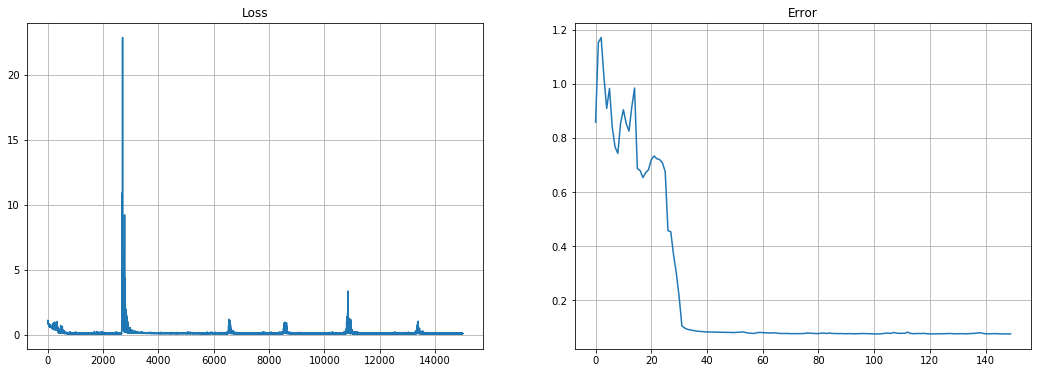

BREAK. There is no improvment for 11000 steps
Best step:  10200
Best Val Error:  0.0749947801232338


In [37]:
loss_history, err_history = [], []
report_frequency = 100
best_err, best_step_err = np.inf, -1
early_stopping_rounds = 11000
lr_decay_steps = 5000
prev_lr_decay_step = 0
max_rounds = -1 # No max round set
max_time = 3600 * 10 # 10 hours

st_time = time.time()
for batch in lib.iterate_minibatches(X_train, y_train,
                                     batch_size=batch_size,
                                     shuffle=True, epochs=float('inf')):
    metrics = trainer.train_on_batch(*batch, device=device)

    loss_history.append(float(metrics['loss']))

    if trainer.step % report_frequency == 0:
        trainer.save_checkpoint()
        trainer.remove_old_temp_checkpoints()
        trainer.average_checkpoints(out_tag='avg')
        trainer.load_checkpoint(tag='avg')

        err = trainer.evaluate_mse(X_valid, y_valid, device=device, batch_size=batch_size * 2)
        if err < best_err:
            best_err = err
            best_step_err = trainer.step
            trainer.save_checkpoint(tag='best')
        err_history.append(err)

        trainer.load_checkpoint()  # last
        
        # Plot loss curve
        clear_output(True)
        plt.figure(figsize=[18, 6])
        plt.subplot(1, 2, 1)
        plt.plot(loss_history)
        plt.title('Loss')
        plt.grid()
        plt.subplot(1, 2, 2)
        plt.plot(err_history)
        plt.title('Error')
        plt.grid()
        plt.show()

#         if trainer.step == 1:
#             print("Step\tVal_Err\tTime(s)")
#         print('{}\t{}\t{:.0f}'.format(trainer.step, np.around(err, 5), time.time() - st_time))

    if trainer.step > 4000 + early_stopping_rounds: # Stop training at least running 4k steps: the steps for temperature annealing
        print('BREAK. There is no improvment for {} steps'.format(early_stopping_rounds))
        break

    if lr_decay_steps > 0 \
            and trainer.step > best_step_err + lr_decay_steps \
            and trainer.step > (prev_lr_decay_step + lr_decay_steps):
        lr_before = trainer.lr
        trainer.decrease_lr(ratio=0.2, min_lr=1e-6)
        prev_lr_decay_step = trainer.step
        print('LR: %.2e -> %.2e' % (lr_before, trainer.lr))

    if 0 < max_rounds < trainer.step:
        print('End. It reaches the maximum rounds %d' % max_rounds)
        break

    if (time.time() - st_time) > max_time:
        print('End. It reaches the maximum run time %d (s)' % max_time)
        break

print("Best step: ", best_step_err)
print("Best Val Error: ", best_err)

In [38]:
max_step = trainer.step
trainer.load_checkpoint(tag='best')
test_err = trainer.evaluate_mse(X_test, y_test, device=device, batch_size=2 * batch_size)

print("Test Error rate: {}".format(test_err))

# Clean up
trainer.remove_old_temp_checkpoints(number_ckpts_to_keep=0)

Test Error rate: 0.07952724397182465


In [39]:
preprocessor.y_std

181.13719

In [40]:
print("The unnormalized RMSE: {}".format(np.sqrt(test_err * (preprocessor.y_std) ** 2)))

The unnormalized RMSE: 51.08172992017829


Then we visualize this model

In [43]:
os.listdir(f'logs/{name}')

['checkpoint_avg.pth', 'checkpoint_best.pth']

In [44]:
max_n_bins = 256

all_X = pd.concat([data['X_train'], data['X_test']], axis=0)

if max_n_bins is not None and max_n_bins > 0:
    all_X = lib.gams.utils.bin_data(all_X, max_n_bins=max_n_bins)

df = model.extract_additive_terms(all_X, norm_fn=preprocessor.transform, y_mu=preprocessor.y_mu, 
                                  y_std=preprocessor.y_std,
                                  device=device, batch_size=2*batch_size)

 25%|██▌       | 19/75 [00:00<00:00, 181.28it/s]

Finish "Run values through model" in 758ms


100%|██████████| 75/75 [00:00<00:00, 197.08it/s]


Finish "Extract values" in 404ms


100%|██████████| 76/76 [00:00<00:00, 510.67it/s]

Finish "Purify interactions to main effects" in 2.7s
Finish "Center main effects" in 2ms
Finish "Construct table" in 155ms


Here we visualize the main effects

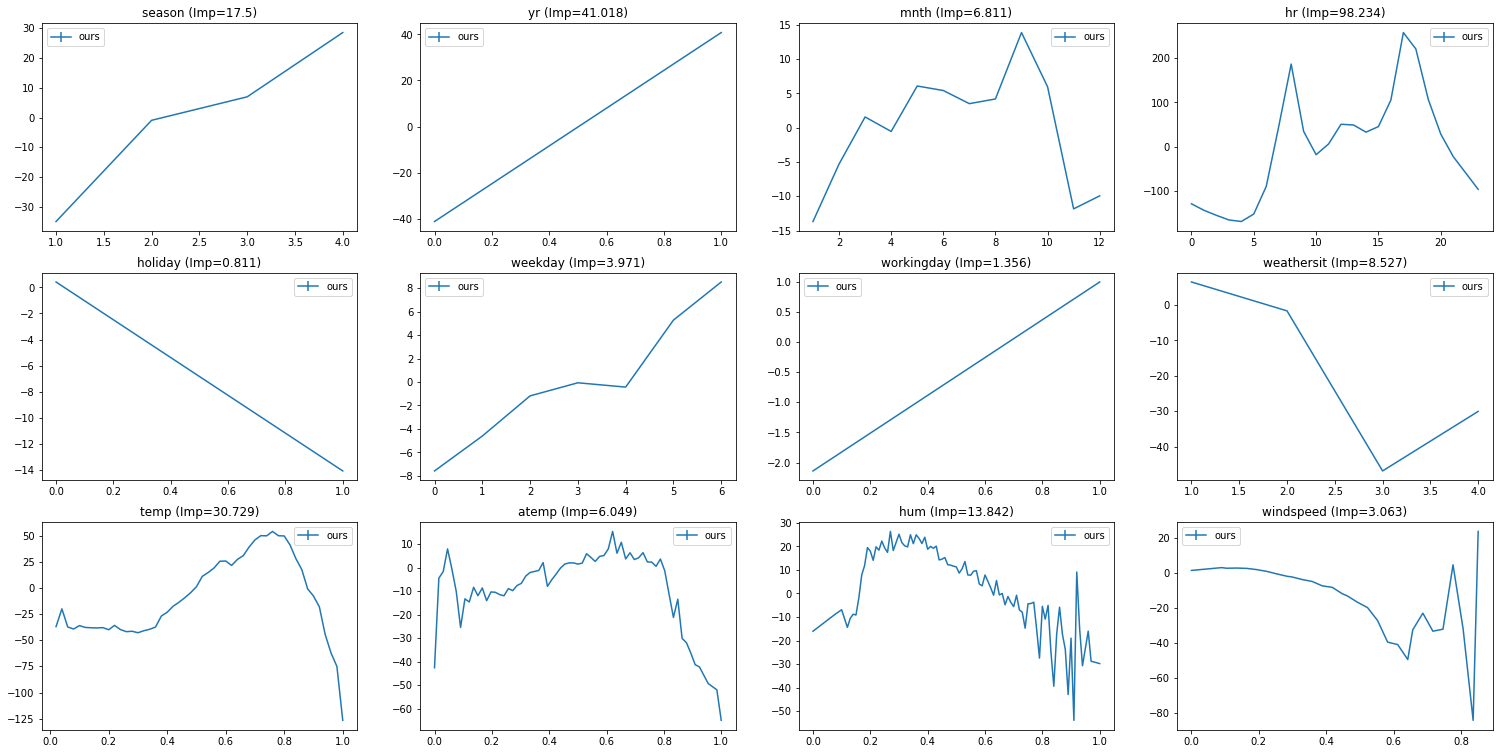

In [47]:
fig, axes = lib.gams.vis_utils.vis_main_effects({'ours': df}, show_density=False)

Top 12 Interaction effects

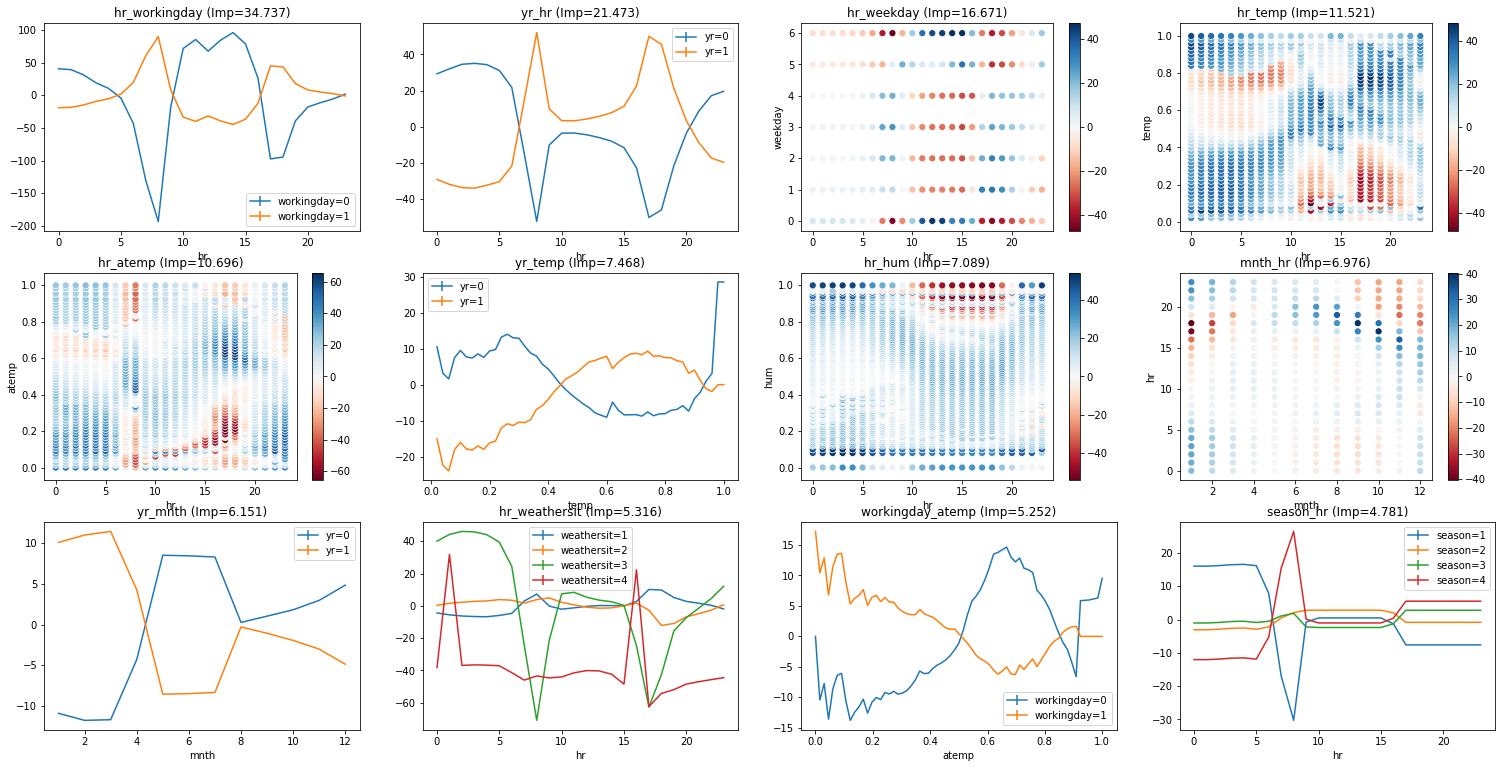

In [46]:
fig, axes = lib.gams.vis_utils.vis_main_effects({'ours': df}, only_interactions=True, top_interactions=12)

Save dataframe

In [ ]:
with open('gam_df.pkl', 'wb') as op:
    pickle.dump(df, op, protocol=pickle.HIGHEST_PROTOCOL)